In [1]:
import control_utils
import controllers
import polytope

import numpy as np
import matplotlib.pyplot as plt
import trajectory_optimizers
import tqdm
import cvxpy as cp
import uncertainty_utils

## Setup Experiments

In [2]:
# Dynamics
A_true = np.array([[1,.2],[0,1]])
B_true = np.array([0,1]).reshape((2,1))
n = A_true.shape[0]
m = B_true.shape[1]
C_true = np.zeros(n)
x_init = np.array([2.7, 2])
state_limits = polytope.box2poly([[-4, 4],[-3, 3]])
input_limits = polytope.box2poly([[-2, 2]])

# LQR Cost:
Q = np.eye(n)
R = np.eye(m)

# Noise and Disturbances
process_noise_var = 1e-3
process_noise = process_noise_var * np.eye(n)
t = uncertainty_utils.calc_t(0.95, n)
disturbance_set = uncertainty_utils.get_elipse(t, process_noise, np.zeros(n))
db = t * np.sqrt(process_noise_var)
disturbance_bound = polytope.box2poly([[-db, db],[-db, db]])

# Experiment Details
episode_length = 20
controller_horizon = 3
state_reference = np.zeros(n)
input_reference = np.zeros(m)
state_constraints = (state_limits.A, state_limits.b)
input_constraints = (input_limits.A, input_limits.b)

def sim_traj(A, B, controller, x_init, N=episode_length, process_noise=np.zeros((n,n)), input_limits=np.array([-1e9, 1e9]), solver_helpers=None):
    x_traj = [x_init]
    u_traj = []
    
    x_pred_trajs = []
    u_pred_trajs = []

    for _ in tqdm.tqdm(range(N)):
        if solver_helpers is None:
            u_command = controller.solve(x_traj[-1])
        else: 
            u_command = controller.solve(x_traj[-1], solver_helpers[0], solver_helpers[1])
        if u_command is None:
            print("controller error at iteration %d" %_)
            break
        u = np.minimum(np.maximum(input_limits[0], u_command), input_limits[1])
        x_next = A @ x_traj[-1] + B @ u + np.random.multivariate_normal(np.zeros(x_init.shape[0]), process_noise)

        x_traj.append(x_next)
        u_traj.append(u)
        
        if hasattr(controller, "x_traj"):
            if isinstance(controller.x_traj, cp.Variable):
                x_pred_trajs.append(controller.x_traj.value.T)
                u_pred_trajs.append(controller.u_traj.value.T)
            else:
                x_pred_trajs.append(controller.x_traj)
                u_pred_trajs.append(controller.u_traj)
            
                

    return np.array(x_traj), np.array(u_traj), x_pred_trajs, u_pred_trajs

## Visualize Disturbance Sets

Text(0.5,1,'Disturbance Set')

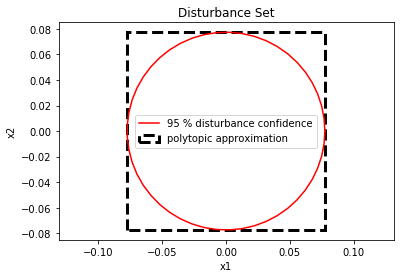

In [3]:
plt.figure()
ax = plt.gca()
plt.axis("equal")
plt.plot(disturbance_set[:,0], disturbance_set[:,1], color="r")
disturbance_bound.plot(ax=ax, alpha=1, color="w", edgecolor="k")
plt.legend(("95 % disturbance confidence", "polytopic approximation"))
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Disturbance Set")

## Tracking MPC

In [4]:
controller = controllers.LTI_MPC_Tracker(A_true, B_true, C_true,
                                         controller_horizon, 
                                         Q, R, state_reference, input_reference,
                                         state_constraints, input_constraints)
controller.build()

In [5]:
x_init_traj, u_init_traj, x_init_preds, u_init_preds = sim_traj(A_true, B_true, controller, x_init, process_noise=process_noise)
h = lambda x, u: x.T @ Q @ x + u.T @ R @ u
init_value_function = control_utils.compute_traj_cost(x_init_traj[:-1,:].T, u_init_traj.T, h)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 32.17it/s]


(-3, 3)

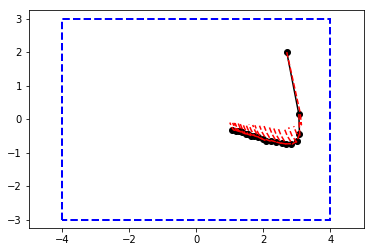

In [6]:
alpha = 1
lw = 2
xlims = (-5,5)
ylims = (-3,3)

plt.figure()
plt.axis("equal")
ax = plt.gca()

plt.plot(x_init_traj[:,0], x_init_traj[:,1], "k-o")
for x_pred in x_init_preds:
    plt.plot(x_pred[:,0], x_pred[:,1], "r--")
state_limits.plot(ax=ax, alpha=alpha, color="w", edgecolor="b", linewidth=lw)

plt.xlim(xlims)
plt.ylim(ylims)

## MPC

In [7]:
controller = controllers.LTI_MPC(A_true, B_true, C_true,
                                         controller_horizon, 
                                         Q, R, state_reference, input_reference,
                                         state_constraints, input_constraints)
controller.build()

In [8]:
x_mpc_traj, u_mpc_traj, x_mpc_preds, u_mpc_preds = sim_traj(A_true, B_true, controller, x_init, process_noise=process_noise)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 31.35it/s]


(-3, 3)

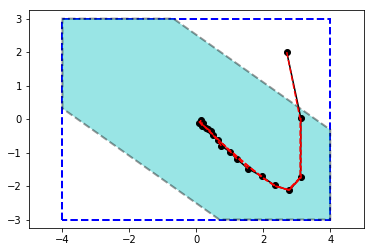

In [9]:
plt.figure()
plt.axis("equal")
ax = plt.gca()

plt.plot(x_mpc_traj[:,0], x_mpc_traj[:,1], "k-o")
for x_pred in x_mpc_preds:
    plt.plot(x_pred[:,0], x_pred[:,1], "r--")

X_terminal = polytope.Polytope(*controller.terminal_constraint)
state_limits.plot(ax=ax, alpha=alpha, color="w", edgecolor="b", linewidth=lw)
X_terminal.plot(ax=ax, alpha=.4, color="c", linewidth=lw)

plt.xlim(xlims)
plt.ylim(ylims)

## Tube MPC

In [10]:
controller = controllers.LTI_Tube_MPC(A_true, B_true, C_true,
                                         controller_horizon, 
                                         Q, R, state_reference, input_reference, 
                                         state_constraints, input_constraints)
controller.build((disturbance_bound.A, disturbance_bound.b))

In [11]:
x_tube_traj, u_tube_traj, x_tube_preds, u_tube_preds = sim_traj(A_true, B_true, controller, x_init, process_noise=process_noise)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 32.21it/s]


(-3, 3)

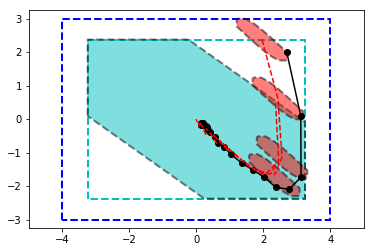

In [12]:
plt.figure()
plt.axis("equal")
ax = plt.gca()

state_limits.plot(ax=ax, alpha=1, color="w", edgecolor="b", linewidth=lw)
X_bar = polytope.Polytope(*controller.state_constraints)
X_bar.plot(ax=ax, alpha=1, color="w", linewidth=lw, edgecolor="c")

plt.plot(x_tube_traj[:,0], x_tube_traj[:,1], "k-o")
for x_pred in x_tube_preds:
    plt.plot(x_pred[:,0], x_pred[:,1], "r--")

X_terminal = polytope.Polytope(*controller.terminal_constraint)
M = polytope.Polytope(*controller.init_constraint)

X_terminal.plot(ax=ax, alpha=0.5, color="c", linewidth=lw)

for x in np.rollaxis(x_tube_preds[0], 0):
    Mx = control_utils.poly_translate(M, x)
    Mx.plot(ax=ax, alpha=.5, color="r", linewidth=lw)

plt.xlim(xlims)
plt.ylim(ylims)

## Learning MPC

In [17]:
num_episodes = 10
controller = controllers.LTI_LMPC(A_true, B_true, C_true,
                                         controller_horizon, 
                                         Q, R, state_reference, input_reference, 
                                         state_constraints, input_constraints)
h = lambda x, u: x.T @ Q @ x + u.T @ R @ u
value_function = control_utils.compute_traj_cost(x_mpc_traj[:-1,:].T, u_mpc_traj.T, h)
controller.add_trajectory(x_mpc_traj[:-1,:].T, u_mpc_traj.T, value_function)

In [18]:
for episode in range(num_episodes):
#     print(episode)
    x_traj, u_traj, x_preds, u_preds = sim_traj(A_true, B_true, controller, x_init)
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h)
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 30.10it/s]


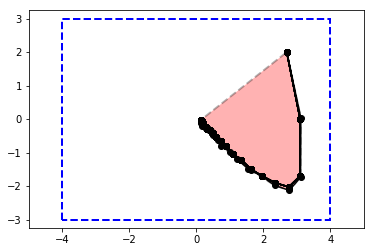

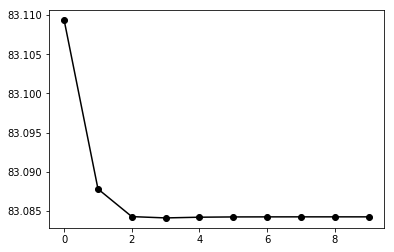

In [19]:
plt.figure()
plt.axis("equal")
ax = plt.gca()

for x_traj in controller.traj_list:
    plt.plot(x_traj[0,:], x_traj[1,:], "k-o")

SS = polytope.qhull(controller.safe_set.value.T)
state_limits.plot(ax=ax, alpha=alpha, color="w", edgecolor="b", linewidth=lw)
SS.plot(ax=ax, alpha=0.3, color="r", linewidth=lw)

plt.xlim(xlims)
plt.ylim(ylims)

plt.figure()
plt.plot([q[0] for q in controller.value_func_list[1:]], "ko-")
lmpc_test_traj = controller.traj_list[1]

## Tube LMPC

In [16]:
num_episodes = 5
w = (disturbance_bound.A, disturbance_bound.b)
controller = controllers.LTI_Tube_LMPC(A_true, B_true, C_true,
                                         controller_horizon, 
                                         Q, R, state_reference, input_reference,
                                         state_constraints, input_constraints, w)
h = lambda x, u: x.T @ Q @ x + u.T @ R @ u
x_nominal, u_nominal = control_utils.compute_nominal_traj(x_mpc_traj.T, u_mpc_traj.T, A_true, B_true, C_true, controller.K)
value_function = control_utils.compute_traj_cost(x_nominal[:,:-1], u_nominal, h)
controller.add_trajectory(x_nominal[:,:-1], u_nominal, value_function)

In [17]:
true_costs = []
true_trajs = []
for episode in range(num_episodes):
    x_traj, u_traj, x_preds, u_preds = sim_traj(A_true, B_true, controller, x_init, process_noise=process_noise)
    x_nominal, u_nominal = control_utils.compute_nominal_traj(x_traj.T, u_traj.T, A_true, B_true, C_true, controller.K)
    value_function = control_utils.compute_traj_cost(x_nominal[:,:-1], u_nominal, h)
    true_costs.append(control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h))
    controller.add_trajectory(x_nominal[:,:-1], u_nominal, value_function)
    true_trajs.append(x_traj)

100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 24.03it/s]


(12, 2)
(35, 2)


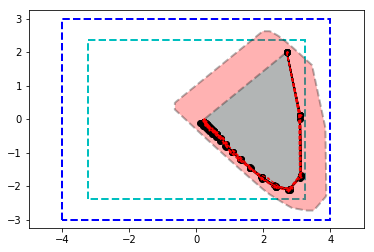

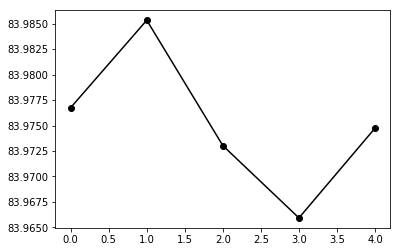

In [18]:
plt.figure()
plt.axis("equal")
ax = plt.gca()

state_limits.plot(ax=ax, alpha=alpha, color="w", edgecolor="b", linewidth=lw)

X_bar = polytope.Polytope(*controller.state_constraints)
X_bar.plot(ax=ax, alpha=1, color="w", linewidth=lw, edgecolor="c")

SS = polytope.qhull(controller.safe_set.value.T)
M = polytope.Polytope(*controller.init_constraint)
RSS = control_utils.minkowski_sum(SS, M)
print(SS.A.shape)
print(M.A.shape)
RSS.plot(ax=ax, alpha=0.3, color="r", linewidth=lw)
SS.plot(ax=ax, alpha=0.3, color="c", linewidth=lw)
for x_traj in controller.traj_list:
    plt.plot(x_traj[0,:], x_traj[1,:], "k-o")
    

for x_traj in true_trajs:
    plt.plot(x_traj[:,0], x_traj[:,1], "r--o", lw=1, markersize=1)
    
plt.xlim(xlims)
plt.ylim(ylims)

plt.figure()
plt.plot([q[0] for q in controller.value_func_list[1:]], "ko-")
# plt.plot([q[0] for q in true_costs], "ro-")

## Robust LMPC

In [19]:
num_episodes = 5
w = (disturbance_bound.A, disturbance_bound.b)
controller = controllers.LTI_Robust_LMPC(A_true, B_true, C_true,
                                         controller_horizon, 
                                         Q, R, state_reference, input_reference, 
                                         state_constraints, input_constraints, w)
h = lambda x, u: x.T @ Q @ x + u.T @ R @ u
x_nominal, u_nominal = control_utils.compute_nominal_traj(x_mpc_traj.T, u_mpc_traj.T, A_true, B_true, C_true, controller.K)
value_function = control_utils.compute_traj_cost(x_nominal[:,:-1], u_nominal, h)
controller.add_trajectory(x_nominal[:,:-1], u_nominal, value_function)

In [20]:
true_costs = []
true_trajs = []
for episode in range(num_episodes):
    x_traj, u_traj, x_preds, u_preds = sim_traj(A_true, B_true, controller, x_init, process_noise=process_noise)
    x_nominal, u_nominal = control_utils.compute_nominal_traj(x_traj.T, u_traj.T, A_true, B_true, C_true, controller.K)
    value_function = control_utils.compute_traj_cost(x_nominal[:,:-1], u_nominal, h)
    true_costs.append(control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h))
    controller.add_trajectory(x_nominal[:,:-1], u_nominal, value_function)
    true_trajs.append(x_traj)

100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 21.08it/s]


(10, 2)
(35, 2)


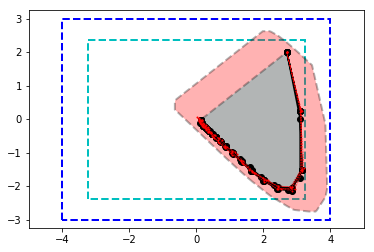

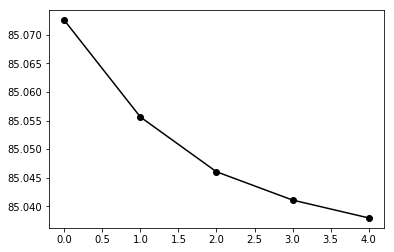

In [21]:
plt.figure()
plt.axis("equal")
ax = plt.gca()

state_limits.plot(ax=ax, alpha=alpha, color="w", edgecolor="b", linewidth=lw)

X_bar = polytope.Polytope(*controller.state_constraints)
X_bar.plot(ax=ax, alpha=1, color="w", linewidth=lw, edgecolor="c")

SS = polytope.qhull(controller.safe_set.value.T)
M = polytope.Polytope(*controller.minimal_invariant)
print(SS.A.shape)
print(M.A.shape)
RSS = control_utils.minkowski_sum(SS, M)

RSS.plot(ax=ax, alpha=0.3, color="r", linewidth=lw)
SS.plot(ax=ax, alpha=0.3, color="c", linewidth=lw)
for x_traj in controller.traj_list:
    plt.plot(x_traj[0,:], x_traj[1,:], "k-o")
    
for x_traj in true_trajs:
    plt.plot(x_traj[:,0], x_traj[:,1], "r--o", lw=.5, markersize=1)
    
plt.xlim(xlims)
plt.ylim(ylims)

plt.figure()
plt.plot([q[0] for q in controller.value_func_list[1:]], "ko-")
# plt.plot([q[0] for q in true_costs], "ro-")
# plt.ylim((82,86))

## Robust Stochastic LMPC

In [22]:
num_episodes = 5
Sigma = process_noise * t ** 2
controller = controllers.LTI_Stochastic_LMPC(A_true, B_true, C_true,
                                         controller_horizon, 
                                         Q, R, state_reference, input_reference,
                                         state_constraints, input_constraints, Sigma)
h = lambda x, u: x.T @ Q @ x + u.T @ R @ u
x_nominal, u_nominal = control_utils.compute_nominal_traj(x_tube_traj.T, u_tube_traj.T, A_true, B_true, C_true, controller.K)
value_function = control_utils.compute_traj_cost(x_nominal[:,:-1], u_nominal, h)
controller.add_trajectory(x_nominal[:,:-1], u_nominal, value_function)

In [23]:
true_costs = []
true_trajs = []
for episode in range(num_episodes):
    x_traj, u_traj, x_preds, u_preds = sim_traj(A_true, B_true, controller, x_init, process_noise=process_noise)
    x_nominal, u_nominal = control_utils.compute_nominal_traj(x_traj.T, u_traj.T, A_true, B_true, C_true, controller.K)
    value_function = control_utils.compute_traj_cost(x_nominal[:,:-1], u_nominal, h)
    true_costs.append(control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h))
    controller.add_trajectory(x_nominal[:,:-1], u_nominal, value_function)
    true_trajs.append(x_traj)

100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 24.26it/s]


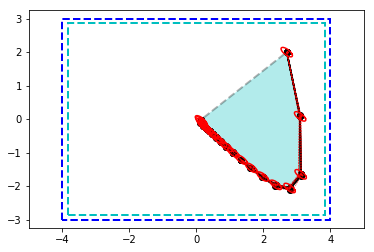

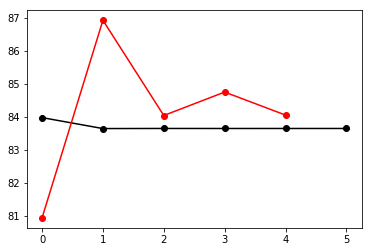

In [24]:
plt.figure()
plt.axis("equal")
ax = plt.gca()

state_limits.plot(ax=ax, alpha=alpha, color="w", edgecolor="b", linewidth=lw)

X_bar = polytope.Polytope(*controller.state_constraints)
X_bar.plot(ax=ax, alpha=1, color="w", linewidth=lw, edgecolor="c")

SS = polytope.qhull(controller.safe_set.value.T)
# M = polytope.Polytope(*controller.minimal_invariant)

SS.plot(ax=ax, alpha=0.3, color="c", linewidth=lw)
for x_traj in controller.traj_list:
    plt.plot(x_traj[0,:], x_traj[1,:], "k-o")
    
for x_traj in true_trajs:
    plt.plot(x_traj[:,0], x_traj[:,1], "r--o", lw=.5, markersize=1)

terminal_cov = controller.minimal_invariant_covariance / (t ** 2)
elipses = uncertainty_utils.get_elipses(t, [terminal_cov] * episode_length, controller.traj_list[-1].T)
for elipse in elipses:
    plt.plot(elipse[:,0], elipse[:,1], "r")

plt.xlim(xlims)
plt.ylim(ylims)

plt.figure()
plt.plot([q[0] for q in controller.value_func_list[:]], "ko-")
plt.plot([q[0] for q in true_costs], "ro-")
# plt.ylim((82,86))

Text(0,0.5,'x2')

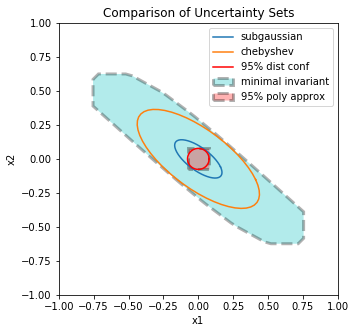

In [25]:
terminal_cov = controller.minimal_invariant_covariance / (t ** 2)
t_cheby = uncertainty_utils.calc_t_chebyshev(0.95, n)
plt.figure(figsize=(5,5))
ax = plt.gca()
terminal_set_boundary = uncertainty_utils.get_elipse(t, terminal_cov, np.zeros(n))
plt.plot(terminal_set_boundary[:,0], terminal_set_boundary[:,1])
terminal_set_boundary_cheby = uncertainty_utils.get_elipse(t_cheby, terminal_cov, np.zeros(n))
plt.plot(terminal_set_boundary_cheby[:,0], terminal_set_boundary_cheby[:,1])
plt.plot(disturbance_set[:,0], disturbance_set[:,1],"r")
M.plot(ax=ax, alpha=0.3, color="c")
disturbance_bound.plot(ax=ax, alpha=0.3, color="r")
plt.xlim((-1,1))
plt.ylim((-1,1))
plt.legend(('subgaussian', 'chebyshev', '95% dist conf', 'minimal invariant', '95% poly approx'))
plt.title("Comparison of Uncertainty Sets")
plt.xlabel("x1")
plt.ylabel("x2")

## Test Trajectory Optimization with Sequential Convex Programming Solver

In [26]:
traj_opt = trajectory_optimizers.SCP_Traj_Opt(episode_length, Q, R, state_reference, input_reference, state_constraints, input_constraints, tolerance=1e-9, regularization=1e0)
traj_opt.build()

In [27]:
As = [A_true for _ in range(episode_length)]
Bs = [B_true for _ in range(episode_length)]

for i in range(20):
    if i == 0:
        x_traj_opt, u_traj_opt, converged = traj_opt.solve_iteration(x_init_traj.T, u_init_traj.T, As, Bs)
    else:
        x_traj_opt, u_traj_opt, converged = traj_opt.solve_iteration(x_traj.T, u_traj.T, As, Bs)
    
    controller = traj_opt.get_controller()
    x_traj, u_traj, _, _ = sim_traj(A_true, B_true, controller, x_init)
    if converged:
        break
print("converged in %d iterations" % traj_opt.i)

100%|███████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 2217.74it/s]


converged in 20 iterations


In [29]:
controller = controllers.LTI_MPC_Tracker(A_true, B_true, C_true,
                                         episode_length, 
                                         Q, R, state_reference, input_reference,
                                         state_constraints, input_constraints)
controller.build()
_ = controller.solve(x_init)
x_true_opt = controller.x_traj.value
u_true_opt = controller.u_traj.value
true_cost = controller.cost

In [30]:
print(np.linalg.norm(u_true_opt - traj_opt.input_traj_list[-1]))
print(np.linalg.norm(x_true_opt - traj_opt.traj_list[-1]))

1.054056154054796e-05
6.964942559381415e-06


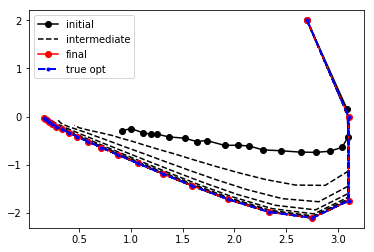

In [31]:
plt.plot(traj_opt.traj_list[0][0,:], traj_opt.traj_list[0][1,:], "k-o", label="initial")
for traj in traj_opt.traj_list[1:-1]:
    plt.plot(traj[0,:], traj[1,:], "k--", label="intermediate")
plt.plot(traj_opt.traj_list[-1][0,:], traj_opt.traj_list[-1][1,:], "r-o", label="final")
plt.plot(x_true_opt[0,:], x_true_opt[1,:], "b--.",label="true opt", lw=2)
ax = plt.gca()
h, l = ax.get_legend_handles_labels()
plt.legend([h[0], h[1], h[-2], h[-1]], [l[0], l[1], l[-2], l[-1]])

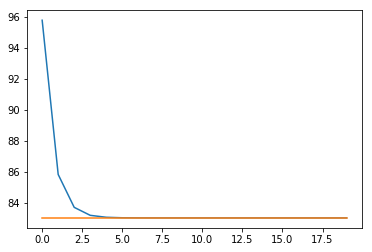

In [32]:
plt.plot(traj_opt.solution_costs)
plt.plot(np.arange(len(traj_opt.solution_costs)), np.ones(len(traj_opt.solution_costs)) * true_cost)

## Test SCP LMPC

In [22]:
def get_linearizations(x_traj, u_traj):
#     print(u_traj.shape)
    return [A_true] * u_traj.shape[1], [B_true] * u_traj.shape[1], None

def estimate_traj(x0, u_traj):
    x_sim = [x0]
    for u in np.rollaxis(u_traj, 1):
        x = A_true @ x_sim[-1] + B_true @ u
        x_sim.append(x)
    return np.array(x_sim).T, u_traj

In [27]:
n_safe_set_it = 1
safe_set_size = u_init_traj.shape[0]
n_iter = 2
regularization = 1e-20

controller = controllers.Local_SCP_LMPC(controller_horizon, Q, R, 
                                            state_reference, input_reference, 
                                            state_constraints, input_constraints, 
                                            n_safe_set_it, safe_set_size, 
                                            n_iter=n_iter, tolerance=1e-3, regularization=regularization)
value_function = control_utils.compute_traj_cost(x_mpc_traj[:-1,:].T, u_mpc_traj.T, h)
controller.add_trajectory(x_mpc_traj[:-1,:].T, u_mpc_traj.T, value_function)
controller.build()

In [28]:
for episode in range(10):
    x_traj, u_traj, x_preds, u_preds = sim_traj(A_true, B_true, controller, x_init, solver_helpers=[get_linearizations, estimate_traj])
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h)
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)
    

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

[0.      0.04066 0.05308 0.04587]
[0. 0. 0. 0.]


  5%|████▏                                                                              | 1/20 [00:00<00:02,  8.19it/s]

[0.      0.      0.      0.43224]
[0. 0. 0. 0.]


 10%|████████▎                                                                          | 2/20 [00:00<00:02,  8.78it/s]

[0.      0.      0.      0.46119]
[0. 0. 0. 0.]


 15%|████████████▍                                                                      | 3/20 [00:00<00:01,  8.79it/s]

[0.      0.      0.      0.42134]
[0. 0. 0. 0.]


 20%|████████████████▌                                                                  | 4/20 [00:00<00:01,  8.42it/s]

[0.      0.      0.      0.42018]
[0. 0. 0. 0.]


 25%|████████████████████▊                                                              | 5/20 [00:00<00:01,  8.58it/s]

[0.      0.      0.      0.37947]
[0. 0. 0. 0.]


 30%|████████████████████████▉                                                          | 6/20 [00:00<00:01,  8.56it/s]

[0.      0.      0.      0.30555]
[0. 0. 0. 0.]


 35%|█████████████████████████████                                                      | 7/20 [00:00<00:01,  8.61it/s]

[0.      0.      0.      0.24844]
[0. 0. 0. 0.]


 40%|█████████████████████████████████▏                                                 | 8/20 [00:00<00:01,  8.67it/s]

[0.      0.      0.      0.18782]
[0. 0. 0. 0.]


 45%|█████████████████████████████████████▎                                             | 9/20 [00:01<00:01,  8.68it/s]

[0.      0.      0.      0.14596]
[0. 0. 0. 0.]


 50%|█████████████████████████████████████████                                         | 10/20 [00:01<00:01,  8.74it/s]

[0.      0.      0.      0.09634]
[0. 0. 0. 0.]


 55%|█████████████████████████████████████████████                                     | 11/20 [00:01<00:01,  8.75it/s]

[0.      0.      0.      0.07618]
[0. 0. 0. 0.]


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:01<00:00,  8.77it/s]

[0.     0.     0.     0.0709]
[0. 0. 0. 0.]


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:01<00:00,  8.80it/s]

[0.     0.     0.     0.0575]
[0. 0. 0. 0.]


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:01<00:00,  8.80it/s]

[0.      0.      0.      0.03313]
[0. 0. 0. 0.]


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:01<00:00,  8.84it/s]

[0.      0.      0.      0.02921]
[0. 0. 0. 0.]


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:01<00:00,  8.84it/s]

[0.      0.      0.      0.03978]
[0. 0. 0. 0.]


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:01<00:00,  8.83it/s]

[0.      0.      0.      0.05273]
[0. 0. 0. 0.]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:02<00:00,  8.84it/s]

[0.      0.      0.      0.05273]
[0. 0. 0. 0.]


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:02<00:00,  8.85it/s]

[0.      0.      0.      0.05272]
[0. 0. 0. 0.]


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

[0. 0. 0. 0.]
[0. 0. 0. 0.]


  5%|████▏                                                                              | 1/20 [00:00<00:02,  8.41it/s]

[0.      0.      0.      0.43224]
[0. 0. 0. 0.]


 10%|████████▎                                                                          | 2/20 [00:00<00:02,  8.65it/s]

[0.      0.      0.      0.46119]
[0. 0. 0. 0.]


 15%|████████████▍                                                                      | 3/20 [00:00<00:01,  8.60it/s]

[0.      0.      0.      0.42134]
[0. 0. 0. 0.]


 20%|████████████████▌                                                                  | 4/20 [00:00<00:01,  8.69it/s]

[0.      0.      0.      0.42018]
[0. 0. 0. 0.]


 25%|████████████████████▊                                                              | 5/20 [00:00<00:01,  8.85it/s]

[0.      0.      0.      0.37947]
[0. 0. 0. 0.]


 30%|████████████████████████▉                                                          | 6/20 [00:00<00:01,  8.72it/s]

[0.      0.      0.      0.30555]
[0. 0. 0. 0.]


 35%|█████████████████████████████                                                      | 7/20 [00:00<00:01,  8.56it/s]

[0.      0.      0.      0.24844]
[0. 0. 0. 0.]


 40%|█████████████████████████████████▏                                                 | 8/20 [00:00<00:01,  8.45it/s]

[0.      0.      0.      0.18782]
[0. 0. 0. 0.]


 45%|█████████████████████████████████████▎                                             | 9/20 [00:01<00:01,  8.36it/s]

[0.      0.      0.      0.14596]
[0. 0. 0. 0.]


 50%|█████████████████████████████████████████                                         | 10/20 [00:01<00:01,  8.38it/s]

[0.      0.      0.      0.09634]
[0. 0. 0. 0.]


 55%|█████████████████████████████████████████████                                     | 11/20 [00:01<00:01,  8.29it/s]

[0.      0.      0.      0.07618]
[0. 0. 0. 0.]


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:01<00:00,  8.18it/s]

[0.     0.     0.     0.0709]
[0. 0. 0. 0.]


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:01<00:00,  8.06it/s]

[0.     0.     0.     0.0575]
[0. 0. 0. 0.]


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:01<00:00,  7.95it/s]

[0.      0.      0.      0.03313]
[0. 0. 0. 0.]


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:01<00:00,  7.88it/s]

[0.      0.      0.      0.02921]
[0. 0. 0. 0.]


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:02<00:00,  7.82it/s]

[0.      0.      0.      0.03978]
[0. 0. 0. 0.]


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:02<00:00,  7.66it/s]

[0.      0.      0.      0.05273]
[0. 0. 0. 0.]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:02<00:00,  7.66it/s]

[0.      0.      0.      0.05273]
[0. 0. 0. 0.]


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:02<00:00,  7.64it/s]

[0.      0.      0.      0.05272]
[0. 0. 0. 0.]


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

[0. 0. 0. 0.]
[0. 0. 0. 0.]


  5%|████▏                                                                              | 1/20 [00:00<00:02,  7.80it/s]

[0.      0.      0.      0.43224]
[0. 0. 0. 0.]


 10%|████████▎                                                                          | 2/20 [00:00<00:02,  7.33it/s]

[0.      0.      0.      0.46119]
[0. 0. 0. 0.]


 15%|████████████▍                                                                      | 3/20 [00:00<00:02,  7.26it/s]

[0.      0.      0.      0.42134]
[0. 0. 0. 0.]


 20%|████████████████▌                                                                  | 4/20 [00:00<00:02,  7.27it/s]

[0.      0.      0.      0.42018]
[0. 0. 0. 0.]


 25%|████████████████████▊                                                              | 5/20 [00:00<00:02,  7.30it/s]

[0.      0.      0.      0.37947]
[0. 0. 0. 0.]


 30%|████████████████████████▉                                                          | 6/20 [00:00<00:01,  7.33it/s]

[0.      0.      0.      0.30555]
[0. 0. 0. 0.]


 35%|█████████████████████████████                                                      | 7/20 [00:00<00:01,  7.37it/s]

[0.      0.      0.      0.24844]
[0. 0. 0. 0.]


 40%|█████████████████████████████████▏                                                 | 8/20 [00:01<00:01,  7.50it/s]

[0.      0.      0.      0.18782]
[0. 0. 0. 0.]


 45%|█████████████████████████████████████▎                                             | 9/20 [00:01<00:01,  7.61it/s]

[0.      0.      0.      0.14596]
[0. 0. 0. 0.]


 50%|█████████████████████████████████████████                                         | 10/20 [00:01<00:01,  7.73it/s]

[0.      0.      0.      0.09634]
[0. 0. 0. 0.]


 55%|█████████████████████████████████████████████                                     | 11/20 [00:01<00:01,  7.85it/s]

[0.      0.      0.      0.07618]
[0. 0. 0. 0.]


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:01<00:01,  7.94it/s]

[0.     0.     0.     0.0709]
[0. 0. 0. 0.]


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:01<00:00,  8.01it/s]

[0.     0.     0.     0.0575]
[0. 0. 0. 0.]


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:01<00:00,  8.05it/s]

[0.      0.      0.      0.03313]
[0. 0. 0. 0.]


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:01<00:00,  8.03it/s]

[0.      0.      0.      0.02921]
[0. 0. 0. 0.]


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:02<00:00,  7.99it/s]

[0.      0.      0.      0.03978]
[0. 0. 0. 0.]


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:02<00:00,  7.96it/s]

[0.      0.      0.      0.05273]
[0. 0. 0. 0.]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:02<00:00,  7.90it/s]

[0.      0.      0.      0.05273]
[0. 0. 0. 0.]


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:02<00:00,  7.87it/s]

[0.      0.      0.      0.05272]
[0. 0. 0. 0.]


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

[0. 0. 0. 0.]
[0. 0. 0. 0.]


  5%|████▏                                                                              | 1/20 [00:00<00:02,  6.95it/s]

[0.      0.      0.      0.43224]
[0. 0. 0. 0.]


 10%|████████▎                                                                          | 2/20 [00:00<00:02,  7.16it/s]

[0.      0.      0.      0.46119]
[0. 0. 0. 0.]


 15%|████████████▍                                                                      | 3/20 [00:00<00:02,  7.11it/s]

[0.      0.      0.      0.42134]
[0. 0. 0. 0.]


 20%|████████████████▌                                                                  | 4/20 [00:00<00:02,  7.13it/s]

[0.      0.      0.      0.42018]
[0. 0. 0. 0.]


 25%|████████████████████▊                                                              | 5/20 [00:00<00:02,  7.17it/s]

[0.      0.      0.      0.37947]
[0. 0. 0. 0.]


 30%|████████████████████████▉                                                          | 6/20 [00:00<00:01,  7.21it/s]

[0.      0.      0.      0.30555]
[0. 0. 0. 0.]


 35%|█████████████████████████████                                                      | 7/20 [00:00<00:01,  7.19it/s]

[0.      0.      0.      0.24844]
[0. 0. 0. 0.]


 40%|█████████████████████████████████▏                                                 | 8/20 [00:01<00:01,  7.20it/s]

[0.      0.      0.      0.18782]
[0. 0. 0. 0.]


 45%|█████████████████████████████████████▎                                             | 9/20 [00:01<00:01,  7.19it/s]

[0.      0.      0.      0.14596]
[0. 0. 0. 0.]


 50%|█████████████████████████████████████████                                         | 10/20 [00:01<00:01,  6.99it/s]

[0.      0.      0.      0.09634]
[0. 0. 0. 0.]


 55%|█████████████████████████████████████████████                                     | 11/20 [00:01<00:01,  6.99it/s]

[0.      0.      0.      0.07618]
[0. 0. 0. 0.]


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:01<00:01,  6.98it/s]

[0.     0.     0.     0.0709]
[0. 0. 0. 0.]


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:01<00:01,  6.96it/s]

[0.     0.     0.     0.0575]
[0. 0. 0. 0.]


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:02<00:00,  6.97it/s]

[0.      0.      0.      0.03313]
[0. 0. 0. 0.]


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:02<00:00,  6.96it/s]

[0.      0.      0.      0.02921]
[0. 0. 0. 0.]


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:02<00:00,  6.96it/s]

[0.      0.      0.      0.03978]
[0. 0. 0. 0.]


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:02<00:00,  6.96it/s]

[0.      0.      0.      0.05273]
[0. 0. 0. 0.]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:02<00:00,  6.98it/s]

[0.      0.      0.      0.05273]
[0. 0. 0. 0.]


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:02<00:00,  6.99it/s]

[0.      0.      0.      0.05272]
[0. 0. 0. 0.]


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

[0. 0. 0. 0.]
[0. 0. 0. 0.]


  5%|████▏                                                                              | 1/20 [00:00<00:02,  7.03it/s]

[0.      0.      0.      0.43224]
[0. 0. 0. 0.]


 10%|████████▎                                                                          | 2/20 [00:00<00:02,  6.75it/s]

[0.      0.      0.      0.46119]
[0. 0. 0. 0.]


 15%|████████████▍                                                                      | 3/20 [00:00<00:02,  6.65it/s]

[0.      0.      0.      0.42134]
[0. 0. 0. 0.]


 20%|████████████████▌                                                                  | 4/20 [00:00<00:02,  6.47it/s]

[0.      0.      0.      0.42018]
[0. 0. 0. 0.]


 25%|████████████████████▊                                                              | 5/20 [00:00<00:02,  6.26it/s]

[0.      0.      0.      0.37947]
[0. 0. 0. 0.]


 30%|████████████████████████▉                                                          | 6/20 [00:00<00:02,  6.18it/s]

[0.      0.      0.      0.30555]
[0. 0. 0. 0.]


 35%|█████████████████████████████                                                      | 7/20 [00:01<00:02,  6.08it/s]

[0.      0.      0.      0.24844]
[0. 0. 0. 0.]


 40%|█████████████████████████████████▏                                                 | 8/20 [00:01<00:01,  6.07it/s]

[0.      0.      0.      0.18782]
[0. 0. 0. 0.]


 45%|█████████████████████████████████████▎                                             | 9/20 [00:01<00:01,  6.01it/s]

[0.      0.      0.      0.14596]
[0. 0. 0. 0.]


 50%|█████████████████████████████████████████                                         | 10/20 [00:01<00:01,  6.06it/s]

[0.      0.      0.      0.09634]
[0. 0. 0. 0.]


 55%|█████████████████████████████████████████████                                     | 11/20 [00:01<00:01,  6.15it/s]

[0.      0.      0.      0.07618]
[0. 0. 0. 0.]


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:01<00:01,  6.26it/s]

[0.     0.     0.     0.0709]
[0. 0. 0. 0.]


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:02<00:01,  6.34it/s]

[0.     0.     0.     0.0575]
[0. 0. 0. 0.]


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:02<00:00,  6.43it/s]

[0.      0.      0.      0.03313]
[0. 0. 0. 0.]


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:02<00:00,  6.49it/s]

[0.      0.      0.      0.02921]
[0. 0. 0. 0.]


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:02<00:00,  6.53it/s]

[0.      0.      0.      0.03978]
[0. 0. 0. 0.]


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:02<00:00,  6.48it/s]

[0.      0.      0.      0.05273]
[0. 0. 0. 0.]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:02<00:00,  6.46it/s]

[0.      0.      0.      0.05273]
[0. 0. 0. 0.]


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:02<00:00,  6.40it/s]

[0.      0.      0.      0.05272]
[0. 0. 0. 0.]


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

[0. 0. 0. 0.]
[0. 0. 0. 0.]


  5%|████▏                                                                              | 1/20 [00:00<00:03,  5.84it/s]

[0.      0.      0.      0.43224]
[0. 0. 0. 0.]


 10%|████████▎                                                                          | 2/20 [00:00<00:03,  5.95it/s]

[0.      0.      0.      0.46119]
[0. 0. 0. 0.]


 15%|████████████▍                                                                      | 3/20 [00:00<00:03,  5.45it/s]

[0.      0.      0.      0.42134]
[0. 0. 0. 0.]


 20%|████████████████▌                                                                  | 4/20 [00:00<00:02,  5.54it/s]

[0.      0.      0.      0.42018]
[0. 0. 0. 0.]


 25%|████████████████████▊                                                              | 5/20 [00:00<00:02,  5.48it/s]

[0.      0.      0.      0.37947]
[0. 0. 0. 0.]


 30%|████████████████████████▉                                                          | 6/20 [00:01<00:02,  5.47it/s]

[0.      0.      0.      0.30555]
[0. 0. 0. 0.]


 35%|█████████████████████████████                                                      | 7/20 [00:01<00:02,  5.51it/s]

[0.      0.      0.      0.24844]
[0. 0. 0. 0.]


 40%|█████████████████████████████████▏                                                 | 8/20 [00:01<00:02,  5.54it/s]

[0.      0.      0.      0.18782]
[0. 0. 0. 0.]


 45%|█████████████████████████████████████▎                                             | 9/20 [00:01<00:01,  5.60it/s]

[0.      0.      0.      0.14596]
[0. 0. 0. 0.]


 50%|█████████████████████████████████████████                                         | 10/20 [00:01<00:01,  5.62it/s]

[0.      0.      0.      0.09634]
[0. 0. 0. 0.]


 55%|█████████████████████████████████████████████                                     | 11/20 [00:01<00:01,  5.63it/s]

[0.      0.      0.      0.07618]
[0. 0. 0. 0.]


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:02<00:01,  5.63it/s]

[0.     0.     0.     0.0709]
[0. 0. 0. 0.]


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:02<00:01,  5.61it/s]

[0.     0.     0.     0.0575]
[0. 0. 0. 0.]


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:02<00:01,  5.62it/s]

[0.      0.      0.      0.03313]
[0. 0. 0. 0.]


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:02<00:00,  5.63it/s]

[0.      0.      0.      0.02921]
[0. 0. 0. 0.]


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:02<00:00,  5.62it/s]

[0.      0.      0.      0.03978]
[0. 0. 0. 0.]


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:03<00:00,  5.63it/s]

[0.      0.      0.      0.05273]
[0. 0. 0. 0.]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:03<00:00,  5.62it/s]

[0.      0.      0.      0.05273]
[0. 0. 0. 0.]


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:03<00:00,  5.60it/s]

[0.      0.      0.      0.05272]
[0. 0. 0. 0.]


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

[0. 0. 0. 0.]
[0. 0. 0. 0.]


  5%|████▏                                                                              | 1/20 [00:00<00:03,  6.10it/s]

[0.      0.      0.      0.43224]
[0. 0. 0. 0.]


 10%|████████▎                                                                          | 2/20 [00:00<00:03,  5.77it/s]

[0.      0.      0.      0.46119]
[0. 0. 0. 0.]


 15%|████████████▍                                                                      | 3/20 [00:00<00:02,  5.72it/s]

[0.      0.      0.      0.42134]
[0. 0. 0. 0.]


 20%|████████████████▌                                                                  | 4/20 [00:00<00:02,  5.74it/s]

[0.      0.      0.      0.42018]
[0. 0. 0. 0.]


 25%|████████████████████▊                                                              | 5/20 [00:00<00:02,  5.69it/s]

[0.      0.      0.      0.37947]
[0. 0. 0. 0.]


 30%|████████████████████████▉                                                          | 6/20 [00:01<00:02,  5.72it/s]

[0.      0.      0.      0.30555]
[0. 0. 0. 0.]


 35%|█████████████████████████████                                                      | 7/20 [00:01<00:02,  5.64it/s]

[0.      0.      0.      0.24844]
[0. 0. 0. 0.]


 40%|█████████████████████████████████▏                                                 | 8/20 [00:01<00:02,  5.63it/s]

[0.      0.      0.      0.18782]
[0. 0. 0. 0.]


 45%|█████████████████████████████████████▎                                             | 9/20 [00:01<00:01,  5.65it/s]

[0.      0.      0.      0.14596]
[0. 0. 0. 0.]


 50%|█████████████████████████████████████████                                         | 10/20 [00:01<00:01,  5.68it/s]

[0.      0.      0.      0.09634]
[0. 0. 0. 0.]


 55%|█████████████████████████████████████████████                                     | 11/20 [00:01<00:01,  5.75it/s]

[0.      0.      0.      0.07618]
[0. 0. 0. 0.]


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:02<00:01,  5.83it/s]

[0.     0.     0.     0.0709]
[0. 0. 0. 0.]


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:02<00:01,  5.84it/s]

[0.     0.     0.     0.0575]
[0. 0. 0. 0.]


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:02<00:01,  5.80it/s]

[0.      0.      0.      0.03313]
[0. 0. 0. 0.]


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:02<00:00,  5.78it/s]

[0.      0.      0.      0.02921]
[0. 0. 0. 0.]


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:02<00:00,  5.68it/s]

[0.      0.      0.      0.03978]
[0. 0. 0. 0.]


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:02<00:00,  5.69it/s]

[0.      0.      0.      0.05273]
[0. 0. 0. 0.]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:03<00:00,  5.68it/s]

[0.      0.      0.      0.05273]
[0. 0. 0. 0.]


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:03<00:00,  5.71it/s]

[0.      0.      0.      0.05272]
[0. 0. 0. 0.]


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

[0. 0. 0. 0.]
[0. 0. 0. 0.]


  5%|████▏                                                                              | 1/20 [00:00<00:03,  4.93it/s]

[0.      0.      0.      0.43224]
[0. 0. 0. 0.]


 10%|████████▎                                                                          | 2/20 [00:00<00:03,  5.23it/s]

[0.      0.      0.      0.46119]
[0. 0. 0. 0.]


 15%|████████████▍                                                                      | 3/20 [00:00<00:03,  5.20it/s]

[0.      0.      0.      0.42134]
[0. 0. 0. 0.]


 20%|████████████████▌                                                                  | 4/20 [00:00<00:02,  5.33it/s]

[0.      0.      0.      0.42018]
[0. 0. 0. 0.]


 25%|████████████████████▊                                                              | 5/20 [00:00<00:02,  5.51it/s]

[0.      0.      0.      0.37947]
[0. 0. 0. 0.]


 30%|████████████████████████▉                                                          | 6/20 [00:01<00:02,  5.73it/s]

[0.      0.      0.      0.30555]
[0. 0. 0. 0.]


 35%|█████████████████████████████                                                      | 7/20 [00:01<00:02,  5.75it/s]

[0.      0.      0.      0.24844]
[0. 0. 0. 0.]


 40%|█████████████████████████████████▏                                                 | 8/20 [00:01<00:02,  5.78it/s]

[0.      0.      0.      0.18782]
[0. 0. 0. 0.]


 45%|█████████████████████████████████████▎                                             | 9/20 [00:01<00:01,  5.73it/s]

[0.      0.      0.      0.14596]
[0. 0. 0. 0.]


 50%|█████████████████████████████████████████                                         | 10/20 [00:01<00:01,  5.76it/s]

[0.      0.      0.      0.09634]
[0. 0. 0. 0.]


 55%|█████████████████████████████████████████████                                     | 11/20 [00:01<00:01,  5.77it/s]

[0.      0.      0.      0.07618]
[0. 0. 0. 0.]


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:02<00:01,  5.75it/s]

[0.     0.     0.     0.0709]
[0. 0. 0. 0.]


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:02<00:01,  5.77it/s]

[0.     0.     0.     0.0575]
[0. 0. 0. 0.]


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:02<00:01,  5.73it/s]

[0.      0.      0.      0.03313]
[0. 0. 0. 0.]


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:02<00:00,  5.75it/s]

[0.      0.      0.      0.02921]
[0. 0. 0. 0.]


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:02<00:00,  5.76it/s]

[0.      0.      0.      0.03978]
[0. 0. 0. 0.]


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:02<00:00,  5.75it/s]

[0.      0.      0.      0.05273]
[0. 0. 0. 0.]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:03<00:00,  5.74it/s]

[0.      0.      0.      0.05273]
[0. 0. 0. 0.]


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:03<00:00,  5.75it/s]

[0.      0.      0.      0.05272]
[0. 0. 0. 0.]


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

[0. 0. 0. 0.]
[0. 0. 0. 0.]


  5%|████▏                                                                              | 1/20 [00:00<00:03,  6.22it/s]

[0.      0.      0.      0.43224]
[0. 0. 0. 0.]


 10%|████████▎                                                                          | 2/20 [00:00<00:02,  6.58it/s]

[0.      0.      0.      0.46119]
[0. 0. 0. 0.]


 15%|████████████▍                                                                      | 3/20 [00:00<00:02,  6.88it/s]

[0.      0.      0.      0.42134]
[0. 0. 0. 0.]


 20%|████████████████▌                                                                  | 4/20 [00:00<00:02,  7.09it/s]

[0.      0.      0.      0.42018]
[0. 0. 0. 0.]


 25%|████████████████████▊                                                              | 5/20 [00:00<00:02,  7.13it/s]

[0.      0.      0.      0.37947]
[0. 0. 0. 0.]


 30%|████████████████████████▉                                                          | 6/20 [00:00<00:01,  7.28it/s]

[0.      0.      0.      0.30555]
[0. 0. 0. 0.]


 35%|█████████████████████████████                                                      | 7/20 [00:00<00:01,  7.19it/s]

[0.      0.      0.      0.24844]
[0. 0. 0. 0.]


 40%|█████████████████████████████████▏                                                 | 8/20 [00:01<00:01,  7.20it/s]

[0.      0.      0.      0.18782]
[0. 0. 0. 0.]


 45%|█████████████████████████████████████▎                                             | 9/20 [00:01<00:01,  6.93it/s]

[0.      0.      0.      0.14596]
[0. 0. 0. 0.]


 50%|█████████████████████████████████████████                                         | 10/20 [00:01<00:01,  6.82it/s]

[0.      0.      0.      0.09634]
[0. 0. 0. 0.]


 55%|█████████████████████████████████████████████                                     | 11/20 [00:01<00:01,  6.66it/s]

[0.      0.      0.      0.07618]
[0. 0. 0. 0.]


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:01<00:01,  6.49it/s]

[0.     0.     0.     0.0709]
[0. 0. 0. 0.]


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:02<00:01,  6.43it/s]

[0.     0.     0.     0.0575]
[0. 0. 0. 0.]


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:02<00:00,  6.40it/s]

[0.      0.      0.      0.03313]
[0. 0. 0. 0.]


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:02<00:00,  6.37it/s]

[0.      0.      0.      0.02921]
[0. 0. 0. 0.]


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:02<00:00,  6.32it/s]

[0.      0.      0.      0.03978]
[0. 0. 0. 0.]


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:02<00:00,  6.23it/s]

[0.      0.      0.      0.05273]
[0. 0. 0. 0.]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:02<00:00,  6.16it/s]

[0.      0.      0.      0.05273]
[0. 0. 0. 0.]


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:03<00:00,  6.12it/s]

[0.      0.      0.      0.05272]
[0. 0. 0. 0.]


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

[0. 0. 0. 0.]
[0. 0. 0. 0.]


  5%|████▏                                                                              | 1/20 [00:00<00:03,  5.81it/s]

[0.      0.      0.      0.43224]
[0. 0. 0. 0.]


 10%|████████▎                                                                          | 2/20 [00:00<00:03,  5.44it/s]

[0.      0.      0.      0.46119]
[0. 0. 0. 0.]


 15%|████████████▍                                                                      | 3/20 [00:00<00:03,  5.49it/s]

[0.      0.      0.      0.42134]
[0. 0. 0. 0.]


 20%|████████████████▌                                                                  | 4/20 [00:00<00:02,  5.57it/s]

[0.      0.      0.      0.42018]
[0. 0. 0. 0.]


 25%|████████████████████▊                                                              | 5/20 [00:00<00:02,  5.62it/s]

[0.      0.      0.      0.37947]
[0. 0. 0. 0.]


 30%|████████████████████████▉                                                          | 6/20 [00:01<00:02,  5.68it/s]

[0.      0.      0.      0.30555]
[0. 0. 0. 0.]


 35%|█████████████████████████████                                                      | 7/20 [00:01<00:02,  5.67it/s]

[0.      0.      0.      0.24844]
[0. 0. 0. 0.]


 40%|█████████████████████████████████▏                                                 | 8/20 [00:01<00:02,  5.63it/s]

[0.      0.      0.      0.18782]
[0. 0. 0. 0.]


 45%|█████████████████████████████████████▎                                             | 9/20 [00:01<00:01,  5.61it/s]

[0.      0.      0.      0.14596]
[0. 0. 0. 0.]


 50%|█████████████████████████████████████████                                         | 10/20 [00:01<00:01,  5.59it/s]

[0.      0.      0.      0.09634]
[0. 0. 0. 0.]


 55%|█████████████████████████████████████████████                                     | 11/20 [00:01<00:01,  5.59it/s]

[0.      0.      0.      0.07618]
[0. 0. 0. 0.]


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:02<00:01,  5.58it/s]

[0.     0.     0.     0.0709]
[0. 0. 0. 0.]


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:02<00:01,  5.60it/s]

[0.     0.     0.     0.0575]
[0. 0. 0. 0.]


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:02<00:01,  5.59it/s]

[0.      0.      0.      0.03313]
[0. 0. 0. 0.]


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:02<00:00,  5.60it/s]

[0.      0.      0.      0.02921]
[0. 0. 0. 0.]


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:02<00:00,  5.60it/s]

[0.      0.      0.      0.03978]
[0. 0. 0. 0.]


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:03<00:00,  5.60it/s]

[0.      0.      0.      0.05273]
[0. 0. 0. 0.]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:03<00:00,  5.58it/s]

[0.      0.      0.      0.05273]
[0. 0. 0. 0.]


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:03<00:00,  5.59it/s]

[0.      0.      0.      0.05272]
[0. 0. 0. 0.]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.60it/s]


In [29]:
scp_lmpc_traj = controller.traj_list[1]
print(np.linalg.norm(scp_lmpc_traj - lmpc_test_traj))

2.7409104398396115e-05


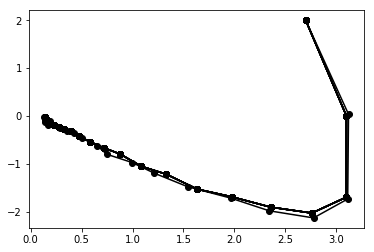

In [30]:
for x_traj in controller.traj_list:
    plt.plot(x_traj[0,:], x_traj[1,:], "k-o")